Importing dependencies

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os
import cv2 as cv

from tqdm.auto import tqdm

from src.dataset import FrameDataset
from src.utils import collate_fn, Averager
from src import config
hparams = config.hparams

We use a label encoder for our classes making sure to set 0 for the background

In [2]:
le = LabelEncoder()
le.fit(['abackground', 'bicycle','human', 'motorcycle', 'vehicle'])

LabelEncoder()

In [3]:
training_data = FrameDataset(root = hparams.train_path, label_encoder = le)
val_data = FrameDataset(root = hparams.val_path, label_encoder=le)

train_dataloader = DataLoader(training_data, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)

Sanity checking data-loader

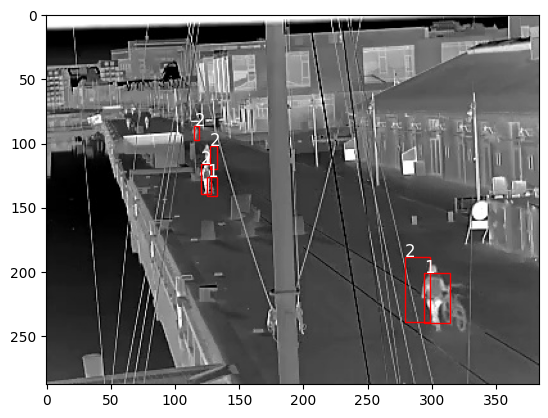

In [9]:
train_features, train_labels = next(iter(val_dataloader))#can check either train or val data
img = train_features[0].numpy().transpose(1, 2 , 0)
plt.imshow(img)

boxes = train_labels[0]['boxes'].numpy()
labels = train_labels[0]['labels'].numpy()
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    plt.text(x1, y1, label, fontsize = 12, c='white')
    plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                    edgecolor='red',
                    facecolor='none',
                    lw=1))

plt.show()

Loading Faster R-CNN with a resnet50 backbone and training

In [5]:
device = torch.device('cuda')
model = fasterrcnn_resnet50_fpn(num_classes=hparams.num_classes)
model.train()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [6]:
#Making sure output directory exists
output_dir = hparams.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Training Loop

In [10]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=hparams.learning_rate, momentum=0.9, weight_decay=0.00001)
train_loss_hist = Averager()
val_loss_hist = Averager()
best_valid_loss=float('inf')



for epoch in range(hparams.max_epochs):
    print(f"\nEPOCH {epoch+1} of {hparams.max_epochs}")
    train_loss_hist.reset()
    #Training step
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))
    for frames, targets in prog_bar:
        
        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(frames, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        break
        

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
        
    #Validation step
    prog_bar = tqdm(val_dataloader, total=len(val_dataloader))
    for frames, targets in prog_bar:

        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(frames, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        val_loss_hist.send(loss_value)
        break

        
     
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    #Saving best model
    if val_loss_hist.value < best_valid_loss:
        best_valid_loss = val_loss_hist.value
        print(f"\nBest validation loss: {best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
        torch.save(model, os.path.join(hparams.output_dir, 'epoch' + str(epoch + 1) + '-best_model.pth'))
print('Training Complete')



EPOCH 1 of 1


  0%|          | 0/942 [00:00<?, ?it/s]

Epoch #1 train loss: 2.132


  0%|          | 0/264 [00:00<?, ?it/s]

Epoch #1 validation loss: 1.819

Best validation loss: 1.8187492730637922

Saving best model for epoch: 1

